In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray as xr
import datetime as dt
from datetime import timedelta
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers


from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer 

2022-12-23 22:48:36.025979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Define paths to training and test data
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

ssrd_cutoff = 10

# Training set
train_files = ["mantua_pt","staten_pt","west_pt"]
x_train_xr, x_length  = prepare_predictor(train_files,train_path,time_reindex=False)
y_train_xr, y_length  = prepare_predictand(train_files,train_path,time_reindex=False)

#replace x_length to account for dropped values
length_mantua = sum(xr.open_dataset("data/train/inputs_mantua_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff)
length_west = sum(xr.open_dataset("data/train/inputs_west_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff)
length_staten = sum(xr.open_dataset("data/train/inputs_staten_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff)
x_length = np.array([length_mantua,length_staten,length_west])
y_length = np.array(sum(xr.open_dataset("data/train/inputs_water_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff))

# Test set
x_test_xr, _ = prepare_predictor('water_pt', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water_pt',data_path=test_path,time_reindex=False)

#dataframes
x_train_df = x_train_xr.to_dataframe().drop(["expver"],axis=1).dropna().reset_index()
x_train_df.ssrd = x_train_df.ssrd / 3600
x_train_df = x_train_df[x_train_df.ssrd>ssrd_cutoff]  # remove ssrd < 10

x_test_df = x_test_xr.to_dataframe().drop(["expver"],axis=1).fillna(0).reset_index()
x_test_df.ssrd = x_test_df.ssrd / 3600
x_test_df = x_test_df[x_test_df.ssrd>ssrd_cutoff]  # remove ssrd < 10

y_train_df = y_train_xr.to_dataframe().dropna()
y_train_df = y_train_df.reset_index().reset_index().merge(x_train_df.reset_index().reset_index()[["index","ssrd"]], on='index', how='right') # remove corresponding ssrd < 10
y_train_df.poa = y_train_df.poa / np.cos(0.174533) #convert to GHI
y_train_df["res"] = y_train_df.poa - y_train_df.ssrd.values
y_train_df = y_train_df.set_index(["time","lat","lon"]).drop(["index","ssrd"],axis=1)

y_test_df = y_test_xr.to_dataframe().dropna()
y_test_df = y_test_df.reset_index().reset_index().merge(x_test_df.reset_index().reset_index()[["index","ssrd"]], on='index', how='right') # remove corresponding ssrd < 10
y_test_df.poa = y_test_df.poa / np.cos(0.174533) #convert to GHI
y_test_df["res"] = y_test_df.poa - y_test_df.ssrd.values
y_test_df = y_test_df.set_index(["time","lat","lon"]).drop(["index","ssrd"],axis=1)

x_train_df = x_train_df.set_index(["time"])
x_test_df = x_test_df.set_index(["time"])

In [4]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()

x_train_df_std   = ((x_train_df - x_mean)/x_std)
x_test_df_std    = ((x_test_df - x_mean)/x_std)

y_mean, y_std = y_train_df.mean(), y_train_df.std()

y_train_df_std   = ((y_train_df - y_mean)/y_std).drop("poa",axis=1)
y_test_df_std    = ((y_test_df - y_mean)/y_std).drop("poa",axis=1)


x_train = x_train_df_std.to_numpy()
y_train = y_train_df_std.to_numpy()
x_test = x_test_df_std.to_numpy()
y_test = y_test_df_std.to_numpy()

print("Before shifting values:")
print(x_train.shape,y_train.shape)
print(x_test.shape, y_test.shape)

start = np.cumsum(x_length) - x_length
end   = np.cumsum(x_length)

slider = 24
x_train_all = []
y_train_all = []

for i in range(len(x_length)):
    
    x_subset = x_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    x_subset = np.array([x_subset[i:i+slider] for i in range(0, x_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, x_length[i]-slider+1)])
    
    x_train_all.append(x_subset)
    y_train_all.append(y_subset)
    
x_train = np.concatenate(x_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
x_test  = np.array([x_test[i:i+slider] for i in range(0, x_test.shape[0]-slider+1)])
y_test  = np.array([y_test[i:i+slider] for i in range(0, y_test.shape[0]-slider+1)])

print("\nAfter shfting time:")
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

Before shifting values:
(15152, 5) (15152, 1)
(5728, 5) (5728, 1)

After shfting time:
(15083, 24, 5) (15083, 1, 1)
(5705, 24, 5) (5705, 24, 1)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 24, 64)            17920     
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 55,169
Trainable params: 55,169
Non-trainable params: 0
_________________________________________________________________

Inital test eval on different site:
179/179 [==============================] - 1s 4ms/step - loss: 1.5842
Epoch 1/50
118/118 [==============================] - 4s 28ms/step - loss: 

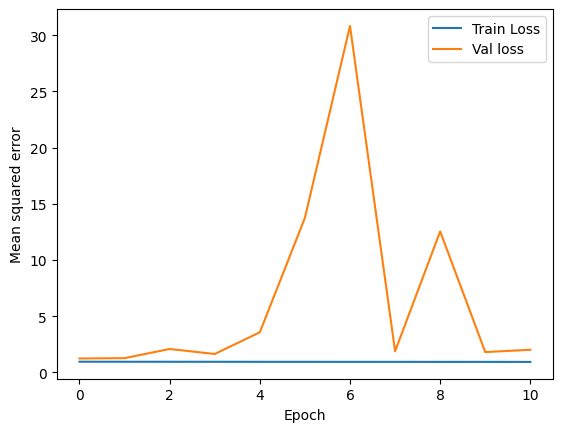

In [35]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1


# Build and compile the model
model = Sequential()
model.add(LSTM(n_neuron,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True,activation=activation))
model.add(LSTM(n_neuron,return_sequences=False,activation=activation))
model.add(Dense(n_neuron,activation=activation))
model.add(Dense(y_train.shape[-1],activation='linear')) 

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()


## Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

print('\nInital test eval on different site:')
model.evaluate(x_test, y_test)

history = model.fit(x_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.5,
                        callbacks=[early_stop],
                        shuffle=False)

print('\nFinal test eval on different site:')
model.evaluate(x_test, y_test)
plot_history(history)

In [42]:
# save the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'lstm_mse.h5'))

#visualizer(model, format='png', view=True)


In [41]:
# reload the saved model
model = load_model(os.path.join(model_path,'ssrd_res_mse_ltsm_model.h5'))

# predict on the test set
y_test_pre = model.predict(x_test)

# Show results with correlation matrix
df_test = x_test_df.reset_index().drop(["lat","lon"],axis=1).set_index("time")
df_test["onsite"] = y_test_df.reset_index().drop(["lat","lon"],axis=1).set_index("time").poa
df_test = df_test[slider-1:]
df_test["res"] = (y_test_pre* y_std.values[1] + y_mean.values[1])
df_test["pred"] = df_test["res"] + df_test.ssrd.values


import math 
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test['onsite'], df_test['pred'])
print("RMS: " +str(math.sqrt(mse)))

df_test.corr()



179/179 [==============================] - 1s 4ms/step
RMS: 147.40344703902832


,ssrd,tcc,t2m,onsite,res,pred
ssrd,1.000000,-0.240856,0.010491,0.876289,0.125093,0.998898
tcc,-0.240856,1.000000,0.079732,-0.286886,-0.166581,-0.247047
t2m,0.010491,0.079732,1.000000,0.002447,0.070819,0.013768
onsite,0.876289,-0.286886,0.002447,1.000000,0.251804,0.882050
res,0.125093,-0.166581,0.070819,0.251804,1.000000,0.171525
pred,0.998898,-0.247047,0.013768,0.882050,0.171525,1.000000


Text(0.5, 1.0, 'Prediction versus ERA5 and Onsite Pryanometer \n April 2021 - July 2022')

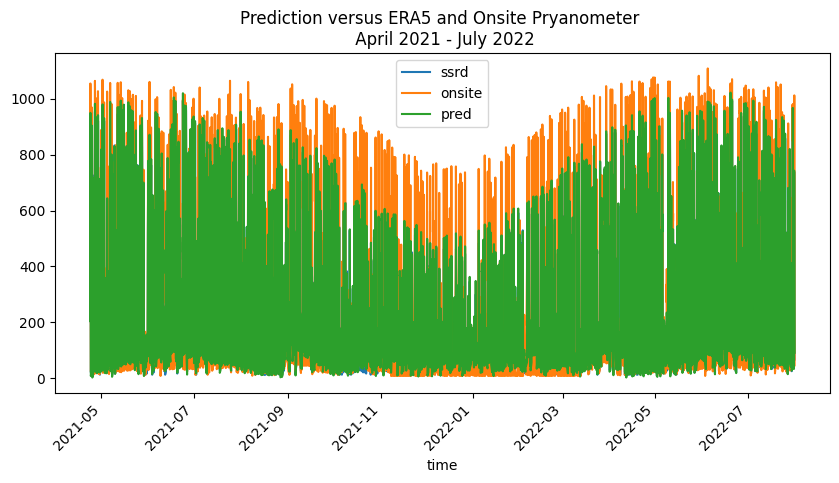

In [33]:
# Show results on total dataset
df_plot = df_test[["ssrd","onsite","pred"]]
df_plot.plot(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Prediction versus ERA5 and Onsite Pryanometer \n April 2021 - July 2022")


Text(0.5, 1.0, 'Predicted vs Actual')

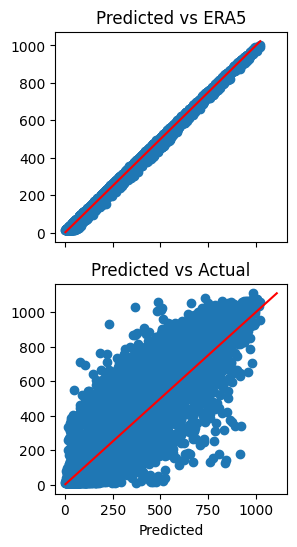

In [34]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(3,6))

# Compare against input ssrd values
ax1.scatter(df_test.pred,df_test.ssrd)
p1 = max(max(df_test.pred), max(df_test.ssrd))
p2 = min(min(df_test.pred), min(df_test.ssrd))
ax1.plot([p1, p2], [p1, p2], 'r-')
ax1.set_title("Predicted vs ERA5")

# Compare against y actual
ax2.scatter(df_test.pred,df_test.onsite)
p1 = max(max(df_test.pred), max(df_test.onsite))
p2 = min(min(df_test.pred), min(df_test.onsite))
ax2.plot([p1, p2], [p1, p2], 'r-')
ax2.set_xlabel("Predicted")
ax2.set_title("Predicted vs Actual")

(array([0, 1, 2, 3]),
 [Text(0, 0, '03-27-22'),
  Text(1, 0, '03-28-22'),
  Text(2, 0, '03-29-22'),
  Text(3, 0, '03-30-22')])

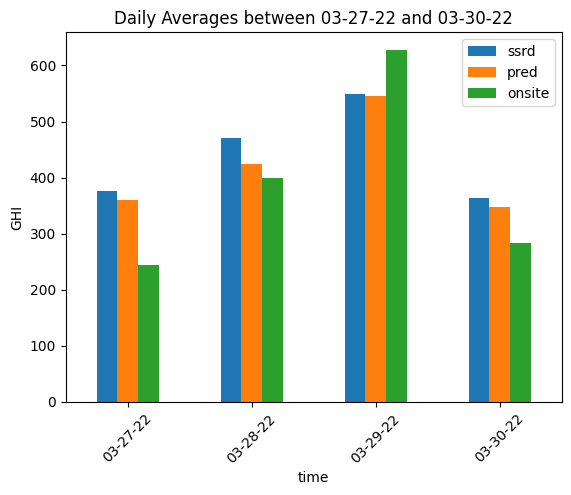

In [124]:
ind = np.arange(10)
width = 0.3       

df_bar = df_test[(df_test.index > dt.datetime(year=2022,month=3,day=27))&(df_test.index < dt.datetime(year=2022,month=3,day=31))].resample("D").mean()
df_bar.index = df_bar.index.strftime("%m-%d-%y")
df_bar[["ssrd","pred","onsite"]].plot(kind='bar')
plt.ylabel("GHI")
plt.title("Daily Averages between " + df_bar.index[0] + " and " + df_bar.index[-1])
plt.xticks(rotation=45)